<a href="https://www.kaggle.com/code/davidfmora/tpsnov22?scriptVersionId=110836578" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Tabular Playground Series November 2022**

**TODO**: 
- Reformat the training code to experiment more easily
- Dig into calibrating the input models via Isotonic regression or Logistic regresion on logits
- Perform Hyperparameter tuning [x]
- Dig into blending the models correctly
- Try some autoML tools


### Problem description

There's a total of 5000 submissions to a binary classification task. Each submission consists of 40000 predictions, amongst 20000 of which we now the true labels.

### Libraries

First import the required dependencies:

In [1]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os 
from pathlib import Path
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from scipy.special import logit
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set_style("dark")
%matplotlib inline

# **Exploratory Data Analysis**

We first load the the data, we will use load a pickle file that contains a numpy array with all the submissions:

In [2]:
%%time
path = Path('/kaggle/input/tabular-playground-series-nov-2022/')
submission = pd.read_csv(path / 'sample_submission.csv', index_col='id')
labels = pd.read_csv(path / 'train_labels.csv', index_col='id')

# load subs file
with open('../input/submissions-pickle-file/subs.pickle', 'rb') as f: 
    X = pickle.load(f)

# list of files in the submission folder
subs = sorted(os.listdir(path / 'submission_files'))

# first 20_0000 subs we know the ground truth
y = labels["label"].values

CPU times: user 136 ms, sys: 1.72 s, total: 1.86 s
Wall time: 13.9 s


We now plot the distribution of the log-loss values of the submissions:

**Insights**

- The distribution of log-loss values seems to be symetric and bimodal.
- There seems to be a lot of submissions with log-loss values close to 0.69 and 0.71
- Most predictions are really bad, as a lot of them perform worse than a dummy model(predicts 0.5 always)

In [3]:
dummy_model = np.zeros((20000,), np.float64) + 0.5
print(f"log-loss of dummy model: {log_loss(y, dummy_model)}")

log-loss of dummy model: 0.6931471805599453


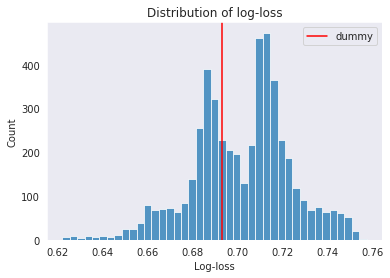

In [4]:
# log-loss values for each submission
subs_loss_vals = np.apply_along_axis(lambda x: log_loss(labels, x), 0, X[:20000])

# histogram
sns.histplot(subs_loss_vals)
plt.axvline(x=log_loss(y, dummy_model), color="r", label="dummy")
plt.xlabel("Log-loss")
plt.title("Distribution of log-loss")
plt.legend()
plt.show()

The columns are alredy ordered by the log-loss:

In [5]:
pd.Series(subs_loss_vals).is_monotonic_increasing


True

### Null values and Outliers

There also does not seem to be any null values in the predictions.

In [6]:
print(f"Number of null values in X: {np.isnan(X).sum()}")
print(f"Number of null values in y: {np.isnan(y).sum()}")

Number of null values in X: 0
Number of null values in y: 0


We can see that although the predicted probabilities should be values between 0 and 1. There are predictions that exceed this limits. We can either clip all the submission values to the interval [0, 1]. Or maybe just dropping these subs is better, it may mitigate overfitting because there is less features

In [7]:
print(f"Minimum predicted value: {X.min()}")
print(f"Maximum predicted value: {X.max()}")

Minimum predicted value: -0.376186
Maximum predicted value: 1.356611


We can see that the classes are balanced.

In [8]:
y.mean()

0.5

### **Predictions histograms**

We next examine a few submissions, we can see that most of them seem to be skeewed towards 1, which is unusual considering that the classes are balanced.

**Insights**

- We somehow have to deal with the diversity of the distributions. An underconfident model (e.g., number 917) should get a higher weight in the ensemble than a more confident model (e.g., number 0). ___How can I identify the confidents models from the undercondident ones.___
- Rank ensembling is an option.
- Maybe we can improve the logloss by transforming the imbalanced predictions to make them more balanced.
- Maybe the word "ensemble" in the competition description has been put there only as a distraction. It will be advantageous if we think of this competition as a standard binary classification problem with 5000 features. We can use any classification model and should not focus on the models which are usually used in ensembling. Of course we need a model which can predict probabilities (e.g., LogisticRegression has a predict_proba function, RidgeClassifier hasn't).


sub 0 validation log-loss: 0.6222863195129075
sub 10 validation log-loss: 0.6272932068380603
sub 20 validation log-loss: 0.6329173955682874
sub 300 validation log-loss: 0.6652266444825161
sub 393 validation log-loss: 0.6698933217723042
sub 400 validation log-loss: 0.670242423685023
sub 500 validation log-loss: 0.6749022400306453
sub 917 validation log-loss: 0.6839509752142919
sub 922 validation log-loss: 0.684041158888528
sub 1451 validation log-loss: 0.6890175814212609
sub 1461 validation log-loss: 0.6891616675209068
sub 1818 validation log-loss: 0.6932630537348184
sub 1834 validation log-loss: 0.6934754748650165
sub 2009 validation log-loss: 0.6962369747130187
sub 2600 validation log-loss: 0.7073460761694988
sub 2811 validation log-loss: 0.7092762948243205
sub 3023 validation log-loss: 0.7106186550330079
sub 3560 validation log-loss: 0.7142806060945864
sub 3851 validation log-loss: 0.7168457191929407
sub 4716 validation log-loss: 0.7371001149790362
sub 4727 validation log-loss: 0.737

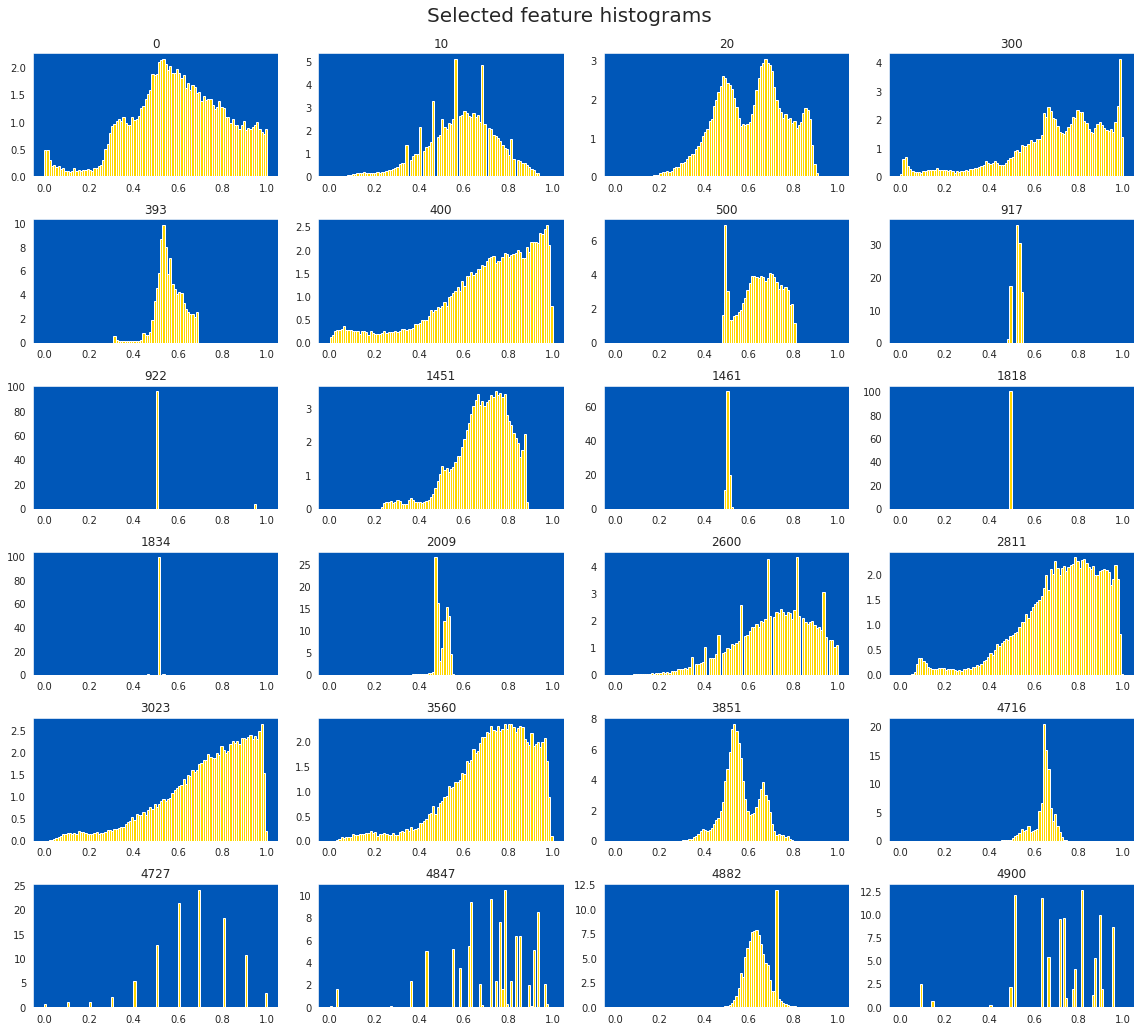

In [9]:
# code extracted from Ambros notebook 

sample_subs = [0, 10, 20, 300, 393, 400, 500, 917,
               922, 1451, 1461, 1818, 1834, 2009, 2600, 2811,
               3023, 3560, 3851, 4716, 4727, 4847, 4882, 4900]
_, axs = plt.subplots(6, 4, figsize=(16, 14))
axs = axs.ravel()
for i, sub in enumerate(sample_subs):
    axs[i].hist(X[:,sub], range=(0, 1), bins=100, density=True, color='#ffd700')
    axs[i].set_title(f"{sub}")
    axs[i].set_facecolor('#0057b8') # blue
    print(f"sub {sub} validation log-loss: {log_loss(y, X[:20_000,sub])}")
plt.tight_layout(h_pad=1.0)
plt.suptitle('Selected feature histograms', y=1.02, fontsize=20)
plt.show()


### Calibration of classifiers

**Question**: ¿Why does calibration the models from the submission improve the logloss of the meta model?

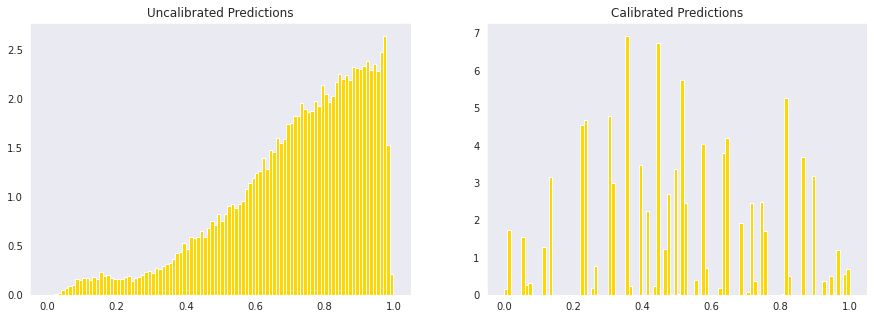

In [10]:
example_sub = X[:, 3023]
iso_reg = IsotonicRegression()
iso_reg.fit(example_sub[:20_000], y)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.ravel()

axs[0].hist(X[:,3023], range=(0, 1), bins=100, density=True, color='#ffd700')
axs[0].set_title("Uncalibrated Predictions")


axs[1].hist(iso_reg.predict(X[:,3023]), range=(0, 1), bins=100, density=True, color='#ffd700')
axs[1].set_title("Calibrated Predictions")

plt.show()

### Principal Components Analysis

In [11]:
%%time

pca = PCA()
pca.fit(X)

CPU times: user 8min 15s, sys: 25.4 s, total: 8min 41s
Wall time: 2min 14s


PCA()

We can see that 95% of the variance is explained by the first 7 components. 

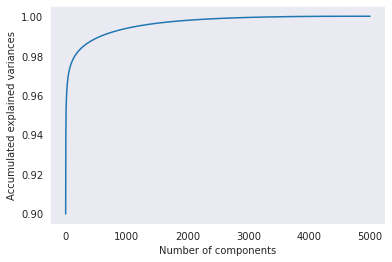

The 7 PCs explain about 95% of the variance


In [12]:
evr = pca.explained_variance_ratio_
cumsum = np.cumsum(evr)
plt.plot(cumsum)
plt.ylabel("Accumulated explained variances")
plt.xlabel("Number of components")
plt.show()

print(f"The {np.argmax(cumsum >= 0.95) + 1} PCs explain about 95% of the variance")

# **Data Cleaning & Feature Engineering**

Ideas
- 

I've read that there are too many features for an ensembling problem and this may cause overfitting. Assuming this is true, how can I reduce the number of features:
- ¿Is this a use case for PCA?
- ¿Just select the top $n$ subs and add more as CV improves?
- Use the top performing subs under log-loss or AUC, is this loss of information significant?

In [13]:
%%time

with open('../input/submissions-pickle-file/subs.pickle', 'rb') as f: 
    X = pickle.load(f)

CPU times: user 136 ms, sys: 1.13 s, total: 1.26 s
Wall time: 1.26 s


In [14]:
# clip (limit) the values in an array to the [0, 1] interval.

# I decided to drop instead of clip
# X = np.clip(X, 0, 1)


Let's drop the outlier submissions:


In [15]:
%%time

mask = ((X >= 0) & (X <= 1)).all(axis=0)
X = X[:, mask]

CPU times: user 1.27 s, sys: 244 ms, total: 1.51 s
Wall time: 1.51 s


Calibrate sumbission models with Isotonic Regression:

In [16]:
def cal(x):
    iso = IsotonicRegression().fit(x[:20_000], y)
    return iso.predict(x)

X = np.apply_along_axis(cal, 0, X)

Split train and test data:

In [17]:
X_dev = X[:20_000]
X_test = X[20_000:]

print(X_dev.shape)

(20000, 4892)


# **Baseline models**

Let's train and cross-validate some models. As the classes are balanced stratified K-fold might not be necessary.

Overall it seems that choosing the top subs(200-300) under log-loss performs better than using PCA, this might be due to the fact that PCA preserves variance, which might mostly come from bad models, but does not take into consideration the loss.

### Logistic Regression


First we try to use PCA to reduce de dataset to 50 components:

In [18]:
%%time

# 0.52465 PL

def cv_logreg(X_dev):
    kfold = StratifiedKFold(shuffle=True, random_state=0)
    scores = []

    for fold, (tr_idx, va_idx) in enumerate(kfold.split(X_dev, y)):
        X_tr = X_dev[tr_idx]
        X_va = X_dev[va_idx]
        y_tr = y[tr_idx]
        y_va = y[va_idx]

        log_reg = make_pipeline(
            PCA(n_components=50),
            LogisticRegression(C=0.2541, solver="saga", max_iter=1000)
        )
        log_reg.fit(X_tr, y_tr)

        y_va_pred = log_reg.predict_proba(X_va)[:,1]
        score = log_loss(y_va, y_va_pred)
        print(f"Fold {fold}: log-loss = {score:.5f}")
        scores.append(score)
        
    print(f"\nAverage log-loss {sum(scores) / len(scores):.5f}\n")

    
cv_logreg(X_dev)

Fold 0: log-loss = 0.53521
Fold 1: log-loss = 0.52023
Fold 2: log-loss = 0.52647
Fold 3: log-loss = 0.52423
Fold 4: log-loss = 0.53145

Average log-loss 0.52752

CPU times: user 1min 30s, sys: 26.2 s, total: 1min 56s
Wall time: 36.2 s


In [19]:
# 0.532309828091498 -> saga
# 0.5356786035569426 -> saga + C=0.01
# 0.5323027248276102 -> lbgfs
# 0.530233561134047 -> top 200 
# 0.5301734827851791 -> top 300
neg_loglosses = cross_val_score(LogisticRegression(C=0.2541,  max_iter=1000, random_state=0),
                                # LogisticRegression(C=0.2541, max_iter=1000, random_state=0), 
                                X_dev[:,:200], 
                                y, 
                                scoring='neg_log_loss', 
                                cv=5
                               )
-neg_loglosses.mean()

0.5252978826341678

### Logistic Regression on Logits


In [20]:
%%time

# 0.5224 -> top 200 + C=0.01

def cv_logreg_logits(X_dev):
    
    str_kfold = StratifiedKFold(shuffle=True, random_state=0)
    scores = []

    for fold, (tr_idx, va_idx) in enumerate(str_kfold.split(X_dev, y)):
        
        X_tr = logit(X_dev[tr_idx].clip(1e-06, 1-1e-06))
        X_va = logit(X_dev[va_idx].clip(1e-06, 1-1e-06))
        y_tr = y[tr_idx]
        y_va = y[va_idx]

        log_reg = make_pipeline(
            # PCA(n_components=0.95, whiten=True, random_state=0), 
            LogisticRegression(C=0.01, max_iter=1000, random_state=0)
        )
        log_reg.fit(X_tr, y_tr)

        y_va_pred = log_reg.predict_proba(X_va)[:,1]
        score = log_loss(y_va, y_va_pred)
        print(f"Fold.{fold}: log-loss = {score:.5f}")
        scores.append(score)

    return sum(scores) / len(scores)

print(f"Avg log-loss: {cv_logreg_logits(X_dev[:,:300])}")

Fold.0: log-loss = 0.52228
Fold.1: log-loss = 0.51264
Fold.2: log-loss = 0.51612
Fold.3: log-loss = 0.51525
Fold.4: log-loss = 0.51999
Avg log-loss: 0.5172557623413854
CPU times: user 6.29 s, sys: 3.06 s, total: 9.35 s
Wall time: 2.39 s


### **LGMB**

In [21]:
%%time

def cv_lgbm(X_dev):
    str_kfold = StratifiedKFold(shuffle=True, random_state=1)
    scores = []

    for fold, (tr_idx, va_idx) in enumerate(str_kfold.split(X_dev, y)):
        X_tr = X_dev[tr_idx]
        X_va = X_dev[va_idx]
        y_tr = y[tr_idx]
        y_va = y[va_idx]

        lgb_md = make_pipeline(LGBMClassifier(max_depth=3, random_state=0))

        lgb_md.fit(X_tr, y_tr)

        lgb_pred = lgb_md.predict_proba(X_va)[:, 1]
        score = log_loss(y_va, lgb_pred)

        print(f"Fold {fold}: log-loss = {score:.5f}")
        scores.append(score)

    print(f"\nAverage log-loss {sum(scores) / len(scores):.5f}\n")


CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 6.68 µs


In [22]:
cv_lgbm(X_dev[:, :250])

Fold 0: log-loss = 0.51871
Fold 1: log-loss = 0.53221
Fold 2: log-loss = 0.52447
Fold 3: log-loss = 0.52579
Fold 4: log-loss = 0.51977

Average log-loss 0.52419



In [23]:
neg_loglosses = cross_val_score(make_pipeline(LGBMClassifier(max_depth=3, random_state=0)),
                                logit(X_dev[:,:200].clip(1e-06, 1-1e-06)), 
                                y, 
                                scoring='neg_log_loss', 
                                cv=5
                               )

Let's tune the hyperparameters of the LGBMClassifier using Optuna:

In [24]:
def objective(trial, data=X_dev[:, :200], target=y):   
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 11, 333),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 64),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.005, 0.1]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 700),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        'cat_feature' : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 
                         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 
                         53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
        'n_jobs' : -1, 
        'random_state': 42,
        'boosting_type': 'gbdt',
        'metric': 'logloss',
        'device': 'gpu'
    }
    model = LGBMClassifier(**params)  
        
    neg_loglosses = cross_val_score(make_pipeline(LGBMClassifier(**params)),
                                data, 
                                target, 
                                scoring='neg_log_loss', 
                                cv=3
                               )
            
    return -neg_loglosses.mean()

In [25]:
best_params = {'reg_alpha': 1.4555494564300762,
               'reg_lambda': 9.030650638749616,
               'num_leaves': 12,
               'min_child_samples': 62,
               'max_depth': 5,
               'learning_rate': 0.01,
               'colsample_bytree': 0.12484633816533297,
               'n_estimators': 626,
               'cat_smooth': 18,
               'cat_l2': 17,
               'min_data_per_group': 50}


In [26]:
# 0.5240184889647151
neg_loglosses = cross_val_score(make_pipeline(LGBMClassifier(**best_params)),
                                X_dev[:,:200], 
                                y, 
                                scoring='neg_log_loss', 
                                cv=5
                               )
-neg_loglosses.mean()

0.5239870558507359

### Extra Trees

In [27]:
%%time
# 0.523 PL

str_kfold = StratifiedKFold(shuffle=True, random_state=1)
scores = []

for fold, (tr_idx, va_idx) in enumerate(str_kfold.split(X_dev, y)):
    X_tr = X_dev[tr_idx]
    X_va = X_dev[va_idx]
    y_tr = y[tr_idx]
    y_va = y[va_idx]
    
    extra_trees = make_pipeline(
        ExtraTreesClassifier(n_estimators=125, min_samples_leaf=12, random_state=1)
    )
    
    extra_trees.fit(X_tr, y_tr)
    
    y_va_pred = extra_trees.predict_proba(X_va)[:,1]
    score = log_loss(y_va, y_va_pred)
    print(f"Fold.{fold}: log-loss = {score:.5f}")
    scores.append(score)

print(f"\nAverage log-loss {sum(scores) / len(scores):.5f}\n")


Fold.0: log-loss = 0.52427
Fold.1: log-loss = 0.53707
Fold.2: log-loss = 0.52655
Fold.3: log-loss = 0.52863
Fold.4: log-loss = 0.52278

Average log-loss 0.52786

CPU times: user 1min 56s, sys: 579 ms, total: 1min 57s
Wall time: 1min 57s


### **XGBoost** 

In [28]:
%%time

def cv_xgboost(X_dev):
    str_kfold = StratifiedKFold(shuffle=True, random_state=1)
    scores = []

    for fold, (tr_idx, va_idx) in enumerate(str_kfold.split(X_dev, y)):
        X_tr = X_dev[tr_idx]
        X_va = X_dev[va_idx]
        y_tr = y[tr_idx]
        y_va = y[va_idx]

        xgbcl = XGBClassifier(n_estimators=50)
        xgbcl.fit(X_tr, y_tr)

        xbg_pred = xgbcl.predict_proba(X_va)[:, 1]
        score = log_loss(y_va, xbg_pred)

        print(f"Fold {fold}: log-loss = {score:.5f}")
        scores.append(score)

    print(f"\nAverage log-loss {sum(scores) / len(scores):.5f}\n")

cv_xgboost(X_dev[:,:200])

Fold 0: log-loss = 0.54325
Fold 1: log-loss = 0.55745
Fold 2: log-loss = 0.55011
Fold 3: log-loss = 0.55373
Fold 4: log-loss = 0.54126

Average log-loss 0.54916

CPU times: user 1min 2s, sys: 53.4 ms, total: 1min 2s
Wall time: 15.9 s
